# Overfitting and Underfitting - IMBD dataset

To prevent overfitting, the best solution is to use *more training data*. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use *techniques like regularization*. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore two common regularization techniques—*weight regularization and dropout*—and use them to improve our IMDB movie review classification notebook.

To recap: here the most common ways to prevent overfitting in neural networks:

- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.

And two important approaches not covered in this guide are:
    
- data-augmentation
- batch normalization.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


## Download the IMDB dataset

Rather than using an embedding as in the previous notebook, here we will multi-hot encode the sentences. This model will quickly overfit to the training set. It will be used to demonstrate when overfitting occurs, and how to fight it.

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

In [3]:
train_data.shape

(25000,)

In [4]:
train_data[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [5]:
import functools
import operator

In [6]:
max(functools.reduce(operator.iconcat, train_data, []))

9999

...so the words are up to 10,000 including special words like \\<UNK\\>

In [7]:
def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results

In [8]:
train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

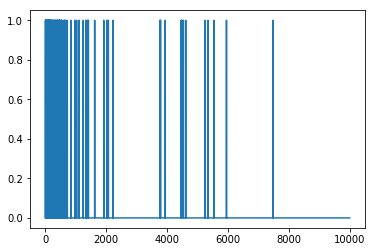

In [9]:
plt.plot(train_data[0])
plt.grid(False)

## Demonstrate overfitting
To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

We'll create a simple model using only Dense layers as a baseline, then create smaller and larger versions, and compare them.

### Create a baseline model

In [10]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works. 
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [11]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 11s - loss: 0.4885 - acc: 0.8070 - binary_crossentropy: 0.4885 - val_loss: 0.3405 - val_acc: 0.8729 - val_binary_crossentropy: 0.3405
Epoch 2/20
 - 8s - loss: 0.2503 - acc: 0.9102 - binary_crossentropy: 0.2503 - val_loss: 0.2834 - val_acc: 0.8879 - val_binary_crossentropy: 0.2834
Epoch 3/20
 - 8s - loss: 0.1820 - acc: 0.9360 - binary_crossentropy: 0.1820 - val_loss: 0.2879 - val_acc: 0.8853 - val_binary_crossentropy: 0.2879
Epoch 4/20
 - 8s - loss: 0.1439 - acc: 0.9511 - binary_crossentropy: 0.1439 - val_loss: 0.3122 - val_acc: 0.8796 - val_binary_crossentropy: 0.3122
Epoch 5/20
 - 8s - loss: 0.1167 - acc: 0.9618 - binary_crossentropy: 0.1167 - val_loss: 0.3388 - val_acc: 0.8742 - val_binary_crossentropy: 0.3388
Epoch 6/20
 - 8s - loss: 0.0932 - acc: 0.9722 - binary_crossentropy: 0.0932 - val_loss: 0.3708 - val_acc: 0.8700 - val_binary_crossentropy: 0.3708
Epoch 7/20
 - 7s - loss: 0.0739 - acc: 0.9796 - binary_crossentropy

In [15]:
baseline_eval = baseline_model.evaluate(test_data, test_labels)

In [22]:
print('Loss: {:.3f}; Accuracy: {:.3f}; Binary cross-entropy: {:.3f}'.format(*baseline_eval))

Loss: 0.832; Accuracy: 0.854; Binary cross-entropy: 0.832


In [23]:
import matplotlib.pyplot as plt

In [31]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_binary_crossentropy', 'loss', 'acc', 'binary_crossentropy'])

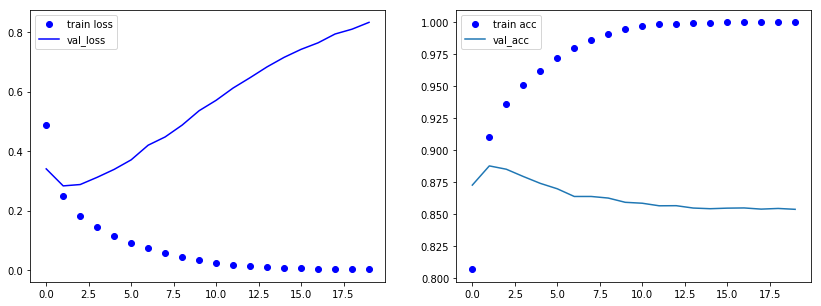

In [53]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(baseline_history.history['loss'], 'bo', label='train loss')
plt.plot(baseline_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(baseline_history.history['acc'], 'bo', label='train acc')
plt.plot(baseline_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

### Create a smaller model
This model is 4x smaller in capacity.

In [39]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [40]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 8s - loss: 0.6163 - acc: 0.6322 - binary_crossentropy: 0.6163 - val_loss: 0.5544 - val_acc: 0.7536 - val_binary_crossentropy: 0.5544
Epoch 2/20
 - 7s - loss: 0.5010 - acc: 0.8245 - binary_crossentropy: 0.5010 - val_loss: 0.4894 - val_acc: 0.8456 - val_binary_crossentropy: 0.4894
Epoch 3/20
 - 7s - loss: 0.4361 - acc: 0.8878 - binary_crossentropy: 0.4361 - val_loss: 0.4466 - val_acc: 0.8633 - val_binary_crossentropy: 0.4466
Epoch 4/20
 - 7s - loss: 0.3840 - acc: 0.9154 - binary_crossentropy: 0.3840 - val_loss: 0.4150 - val_acc: 0.8720 - val_binary_crossentropy: 0.4150
Epoch 5/20
 - 8s - loss: 0.3383 - acc: 0.9336 - binary_crossentropy: 0.3383 - val_loss: 0.3931 - val_acc: 0.8718 - val_binary_crossentropy: 0.3931
Epoch 6/20
 - 9s - loss: 0.2970 - acc: 0.9445 - binary_crossentropy: 0.2970 - val_loss: 0.3690 - val_acc: 0.8784 - val_binary_crossentropy: 0.3690
Epoch 7/20
 - 9s - loss: 0.2597 - acc: 0.9531 - binary_crossentropy:

In [42]:
smaller_eval = smaller_model.evaluate(test_data, test_labels)
print('Loss: {:.3f}; Accuracy: {:.3f}; Binary cross-entropy: {:.3f}'.format(*smaller_eval))

25000/25000 [==============================] - 4s 160us/step
Loss: 0.479; Accuracy: 0.863; Binary cross-entropy: 0.479


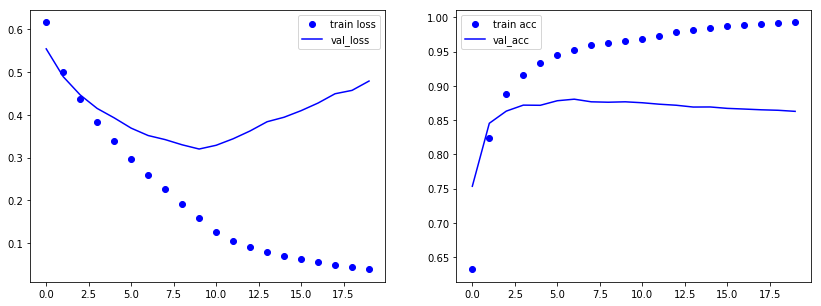

In [54]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(smaller_history.history['loss'], 'bo', label='train loss')
plt.plot(smaller_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(smaller_history.history['acc'], 'bo', label='train acc')
plt.plot(smaller_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

### Create a bigger model
Just to see how fast it overfits.

In [55]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [56]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 36s - loss: 0.3516 - acc: 0.8484 - binary_crossentropy: 0.3516 - val_loss: 0.2991 - val_acc: 0.8796 - val_binary_crossentropy: 0.2991
Epoch 2/20
 - 35s - loss: 0.1430 - acc: 0.9471 - binary_crossentropy: 0.1430 - val_loss: 0.3538 - val_acc: 0.8648 - val_binary_crossentropy: 0.3538
Epoch 3/20
 - 33s - loss: 0.0504 - acc: 0.9853 - binary_crossentropy: 0.0504 - val_loss: 0.4229 - val_acc: 0.8663 - val_binary_crossentropy: 0.4229
Epoch 4/20
 - 35s - loss: 0.0082 - acc: 0.9987 - binary_crossentropy: 0.0082 - val_loss: 0.5847 - val_acc: 0.8696 - val_binary_crossentropy: 0.5847
Epoch 5/20
 - 35s - loss: 8.6408e-04 - acc: 1.0000 - binary_crossentropy: 8.6408e-04 - val_loss: 0.6777 - val_acc: 0.8702 - val_binary_crossentropy: 0.6777
Epoch 6/20
 - 36s - loss: 2.3013e-04 - acc: 1.0000 - binary_crossentropy: 2.3013e-04 - val_loss: 0.7197 - val_acc: 0.8699 - val_binary_crossentropy: 0.7197
Epoch 7/20
 - 34s - loss: 1.3531e-04 - acc: 1.

In [57]:
bigger_eval = bigger_model.evaluate(test_data, test_labels)
print('Loss: {:.3f}; Accuracy: {:.3f}; Binary cross-entropy: {:.3f}'.format(*bigger_eval))

25000/25000 [==============================] - 15s 602us/step
Loss: 0.904; Accuracy: 0.870; Binary cross-entropy: 0.904


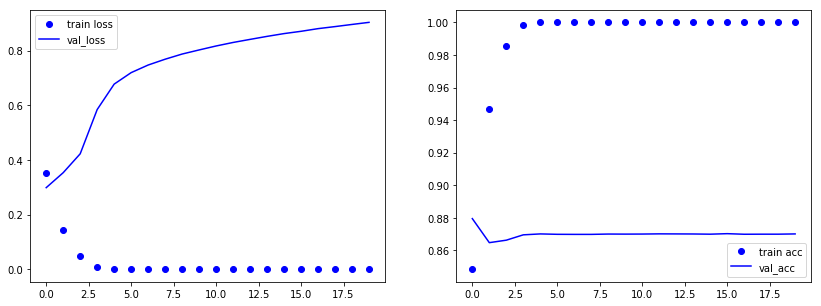

In [58]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(bigger_history.history['loss'], 'bo', label='train loss')
plt.plot(bigger_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(bigger_history.history['acc'], 'bo', label='train acc')
plt.plot(bigger_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

### Plot the training and validation loss
The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model). Here, the smaller network begins overfitting later than the baseline model (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting.

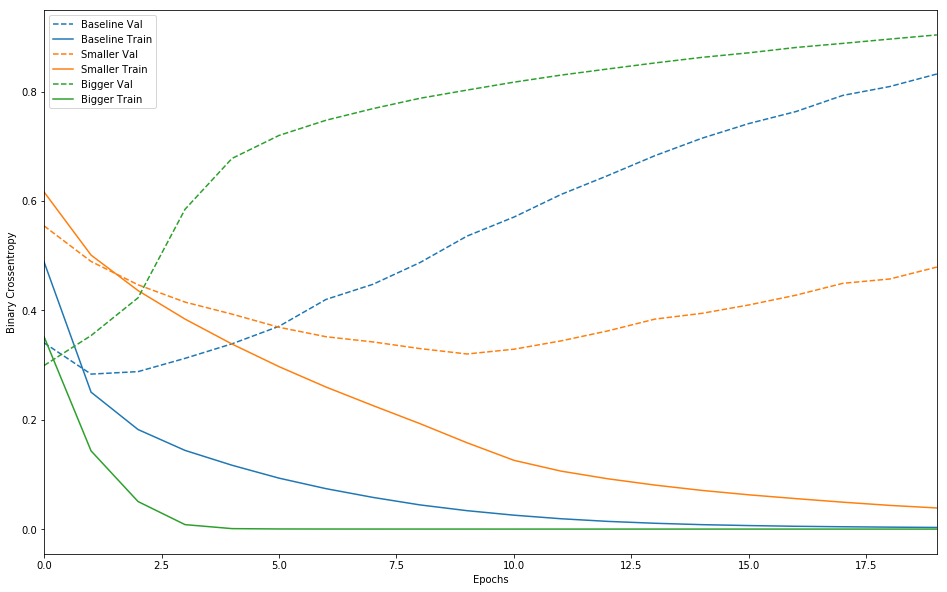

In [59]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

Notice that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

## Strategies
### Add weight regularization

- L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

- L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. 

#### L2 regularization

In [60]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


`l2(0.001)` means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

In [62]:
l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 8s - loss: 0.5039 - acc: 0.8158 - binary_crossentropy: 0.4608 - val_loss: 0.3671 - val_acc: 0.8805 - val_binary_crossentropy: 0.3213
Epoch 2/20
 - 7s - loss: 0.2943 - acc: 0.9143 - binary_crossentropy: 0.2445 - val_loss: 0.3359 - val_acc: 0.8879 - val_binary_crossentropy: 0.2834
Epoch 3/20
 - 7s - loss: 0.2487 - acc: 0.9324 - binary_crossentropy: 0.1940 - val_loss: 0.3425 - val_acc: 0.8843 - val_binary_crossentropy: 0.2860
Epoch 4/20
 - 8s - loss: 0.2252 - acc: 0.9422 - binary_crossentropy: 0.1671 - val_loss: 0.3596 - val_acc: 0.8802 - val_binary_crossentropy: 0.3005
Epoch 5/20
 - 7s - loss: 0.2137 - acc: 0.9481 - binary_crossentropy: 0.1530 - val_loss: 0.3725 - val_acc: 0.8786 - val_binary_crossentropy: 0.3107
Epoch 6/20
 - 7s - loss: 0.2014 - acc: 0.9527 - binary_crossentropy: 0.1390 - val_loss: 0.3903 - val_acc: 0.8726 - val_binary_crossentropy: 0.3276
Epoch 7/20
 - 7s - loss: 0.1948 - acc: 0.9558 - binary_crossentropy:

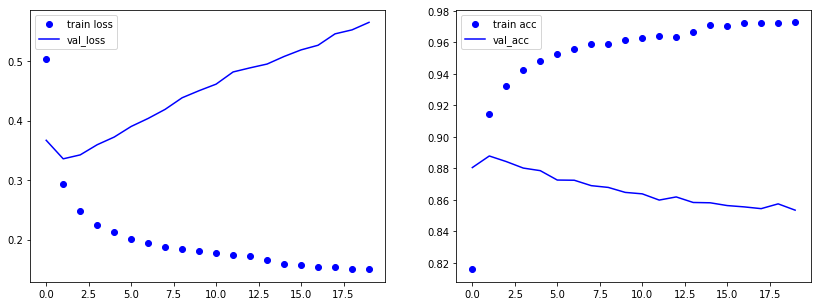

In [63]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(l2_model_history.history['loss'], 'bo', label='train loss')
plt.plot(l2_model_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(l2_model_history.history['acc'], 'bo', label='train acc')
plt.plot(l2_model_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

#### L1 regularization

In [65]:
l1_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l1(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l1(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l1_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [66]:
l1_model_history = l1_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 1.1002 - acc: 0.7902 - binary_crossentropy: 0.5408 - val_loss: 0.6148 - val_acc: 0.8489 - val_binary_crossentropy: 0.4268
Epoch 2/20
 - 9s - loss: 0.5525 - acc: 0.8600 - binary_crossentropy: 0.3779 - val_loss: 0.5259 - val_acc: 0.8616 - val_binary_crossentropy: 0.3541
Epoch 3/20
 - 8s - loss: 0.5052 - acc: 0.8672 - binary_crossentropy: 0.3337 - val_loss: 0.5072 - val_acc: 0.8638 - val_binary_crossentropy: 0.3366
Epoch 4/20
 - 8s - loss: 0.4854 - acc: 0.8746 - binary_crossentropy: 0.3163 - val_loss: 0.4950 - val_acc: 0.8670 - val_binary_crossentropy: 0.3262
Epoch 5/20
 - 8s - loss: 0.4724 - acc: 0.8766 - binary_crossentropy: 0.3059 - val_loss: 0.4795 - val_acc: 0.8724 - val_binary_crossentropy: 0.3133
Epoch 6/20
 - 7s - loss: 0.4617 - acc: 0.8804 - binary_crossentropy: 0.2972 - val_loss: 0.4761 - val_acc: 0.8722 - val_binary_crossentropy: 0.3124
Epoch 7/20
 - 7s - loss: 0.4561 - acc: 0.8822 - binary_crossentropy:

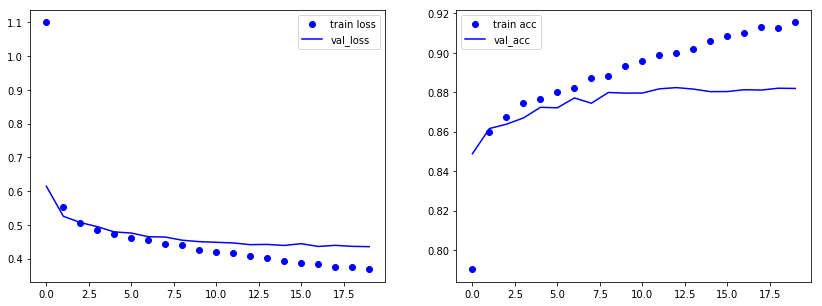

In [67]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(l1_model_history.history['loss'], 'bo', label='train loss')
plt.plot(l1_model_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(l1_model_history.history['acc'], 'bo', label='train acc')
plt.plot(l1_model_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

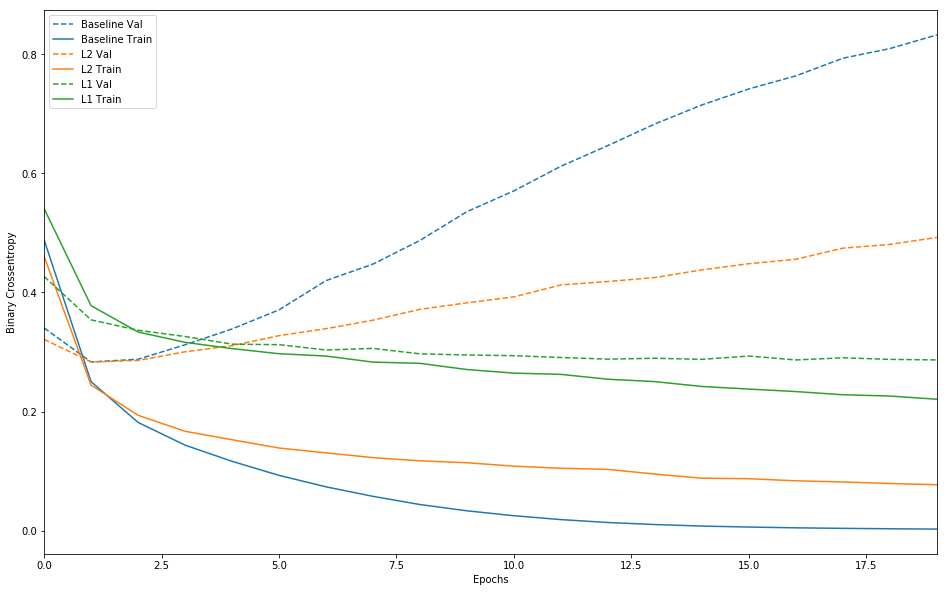

In [68]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history),
              ('l1', l1_model_history)])

### Dropout
Developed by Hinton and his students at the University of Toronto. In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

In [69]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 8s - loss: 0.6340 - acc: 0.6416 - binary_crossentropy: 0.6340 - val_loss: 0.5057 - val_acc: 0.8533 - val_binary_crossentropy: 0.5057
Epoch 2/20
 - 7s - loss: 0.4649 - acc: 0.8044 - binary_crossentropy: 0.4649 - val_loss: 0.3500 - val_acc: 0.8801 - val_binary_crossentropy: 0.3500
Epoch 3/20
 - 7s - loss: 0.3466 - acc: 0.8742 - binary_crossentropy: 0.3466 - val_loss: 0.2920 - val_acc: 0.8859 - val_binary_crossentropy: 0.2920
Epoch 4/20
 - 7s - loss: 0.2849 - acc: 0.9032 - binary_crossentropy: 0.2849 - val_loss: 0.2777 - val_acc: 0.8876 - val_binary_crossentropy: 0.2777
Epoch 5/20
 - 7s - loss: 0.2447 - acc: 0.9192 - binary_crossentropy: 0.2447 - val_loss: 0.2798 - val_acc: 0.8873 - val_binary_crossentropy: 0.2798
Epoch 6/20
 - 7s - loss: 0.2114 - acc: 0.9322 - binary_crossentropy: 0.2114 - val_loss: 0.2925 - val_acc: 0.8852 - val_binary_crossentropy: 0.2925
Epoch 7/20
 - 7s - loss: 0.1834 - acc: 0.9412 - binary_crossentropy:

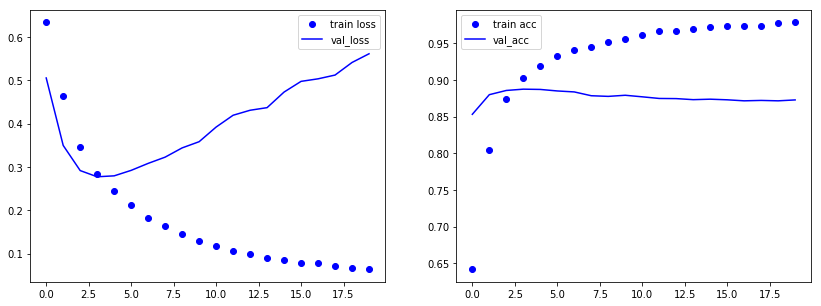

In [70]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(dpt_model_history.history['loss'], 'bo', label='train loss')
plt.plot(dpt_model_history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(dpt_model_history.history['acc'], 'bo', label='train acc')
plt.plot(dpt_model_history.history['val_acc'], 'b-', label='val_acc')
plt.legend()
plt.grid(False)

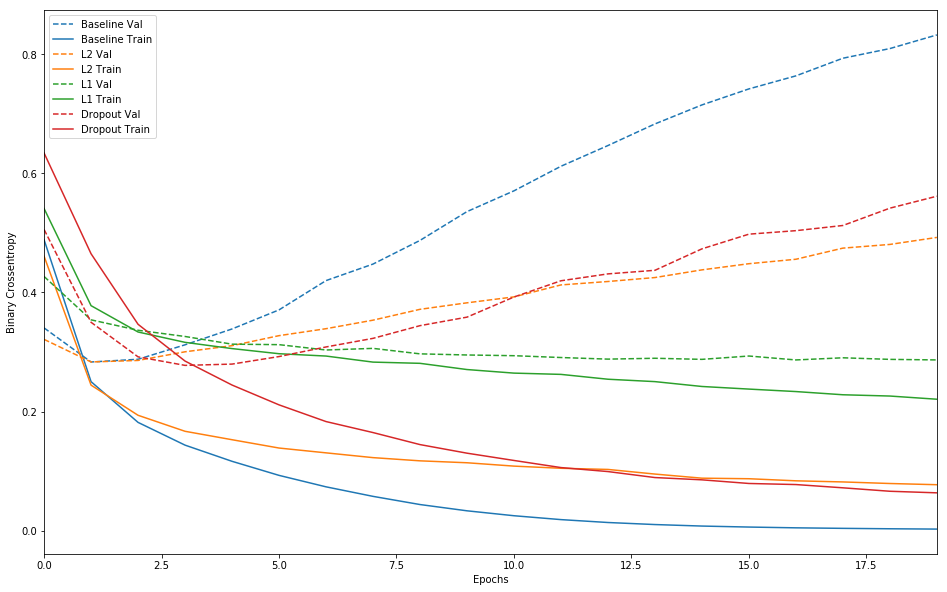

In [72]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history),
              ('l1', l1_model_history),
              ('dropout', dpt_model_history)])